# Canon Voronoi Analysis Notebook

This notebook provides a clean, minimal workflow for Voronoi-based analysis and plotting, inspired by `vornoi_personality.ipynb` but refactored to use simple function calls exposed by `voronoi_utils.py`.

Steps:
- Configure paths and parameters
- Load frames
- Coordination analysis (full and metals-only)
- Build Voronoi graphs and summarize properties
- Metals-only cluster analysis and plots
- Voronoi edge network summary
- Temporal evolution of graph properties
- Optional: OVITO bond network summary


In [1]:
# Imports and configuration
import os
from pathlib import Path
import numpy as np
from ase.io import read

from voronoi_utils import (
    build_voronoi_graph,
    build_voronoi_graph_metals_only,
    analyze_voronoi_coordination,
    analyze_voronoi_coordination_metals_only,
    analyze_graph_properties,
    analyze_temporal_graph_properties,
    plot_temporal_graph_properties,
    analyze_voronoi_clusters,
    summarize_voronoi_edge_network,
    plot_coordination_histograms,
    plot_graph_structure,
    plot_cluster_size_distribution,
    plot_cluster_composition_analysis,
    plot_3d_cluster_visualization,
    plot_3d_cluster_with_graph
)

# Configure dataset path and parameters
DATA_DIR = Path('/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.60/T1200K')
LAMMPS_FILE = DATA_DIR / 'dump.lammpstrj'
FRAME_SLICE = '-501:-1'  # last 500 frames
MIN_AREA = 0.2  # facet area threshold
METAL_SPECIES = ['Pu', 'Na']

print('Reading frames...')
atoms_list = read(str(LAMMPS_FILE), index=FRAME_SLICE)
print(f'Loaded {len(atoms_list)} frames, atoms per frame: {len(atoms_list[0])}')

names = np.array(atoms_list[0].get_chemical_symbols())
all_species = sorted(set(names))
print('Species:', all_species)


/global/homes/p/pvashi/.conda/envs/metaml/lib/python3.11/site-packages/ase/dft/__init__.py:2: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.integrate import trapezoid


Reading frames...
Loaded 500 frames, atoms per frame: 2048
Species: [np.str_('Cl'), np.str_('Na'), np.str_('Pu')]


In [2]:
import numpy as np
from voronoi_utils import build_voronoi_graph, build_voronoi_graph_metals_only, analyze_graph_properties

sample = atoms_list[0]

def edge_areas(G):
    return np.array([d['area'] for _,_,d in G.edges(data=True)], float)

# Get area distribution with no threshold
G0 = build_voronoi_graph(sample, min_area=0.0)
areas_full = edge_areas(G0)
Gm0 = build_voronoi_graph_metals_only(sample, min_area=0.0, metal_species=METAL_SPECIES)
areas_metals = edge_areas(Gm0)

# Option A: quantile-based thresholds
t_full = float(np.quantile(areas_full, 0.02))
t_metals = float(np.quantile(areas_metals, 0.02))

# Option B: sweep to find elbow while staying connected
candidates = np.quantile(areas_metals, np.linspace(0.02, 0.8, 21))  # scan lowest 20%
metrics = []
for t in candidates:
    G = build_voronoi_graph_metals_only(sample, min_area=float(t), metal_species=METAL_SPECIES)
    props = analyze_graph_properties(G)
    lcf = props.get('largest_component_fraction', 1.0 if props.get('is_connected', False) else 0.0)
    metrics.append((float(t), props['avg_degree'], lcf))

# Pick smallest t with lcf >= 0.95 and avg_degree past its first sharp drop
chosen = next((t for t, deg, lcf in metrics if lcf >= 0.95), float(np.quantile(areas_metals, 0.02)))
MIN_AREA = chosen
print("Chosen MIN_AREA =", MIN_AREA)

Chosen MIN_AREA = 0.020379376858472825


In [3]:
MIN_AREA=50

Analyzing coordination (all species)...
Plotting coordination for Cl


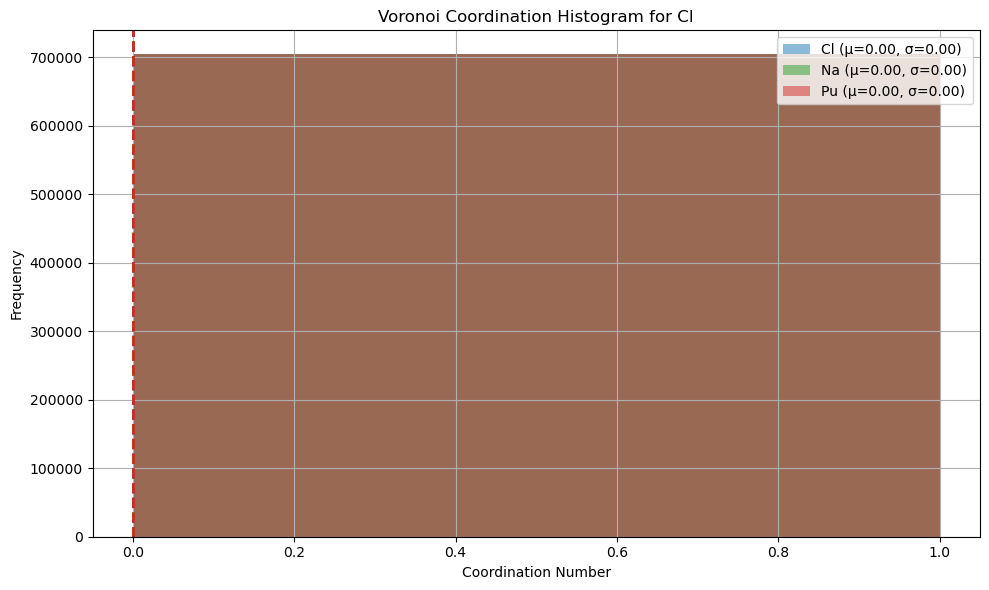

Plotting coordination for Na


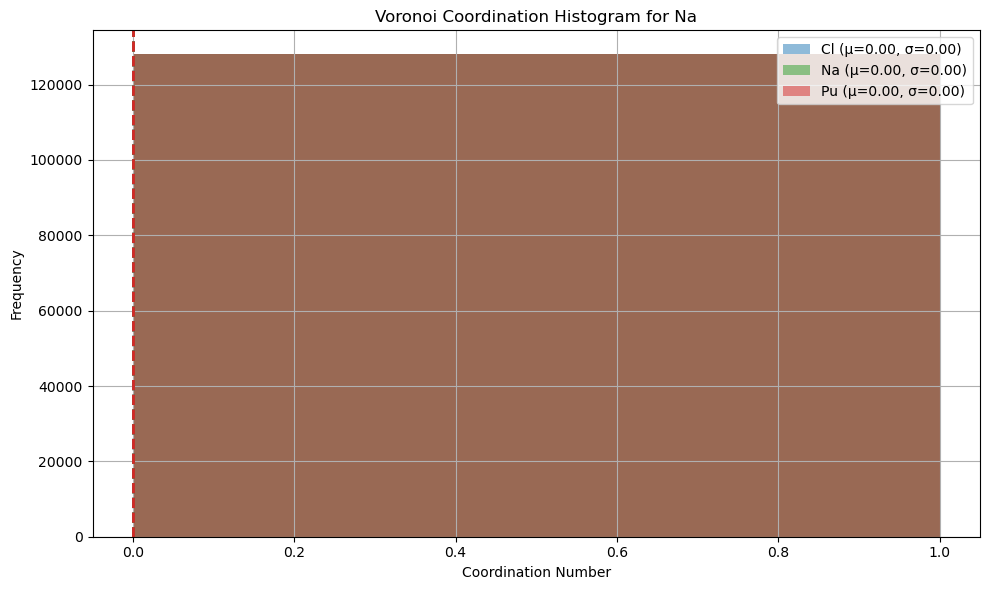

Plotting coordination for Pu


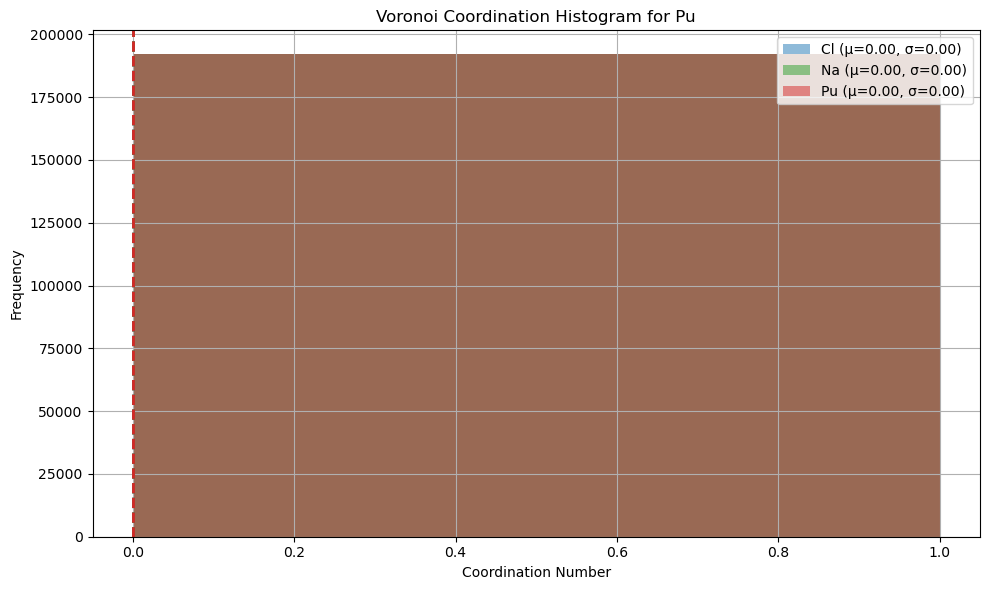

Analyzing coordination (metals-only)...
Plotting metal-metal coordination for Pu


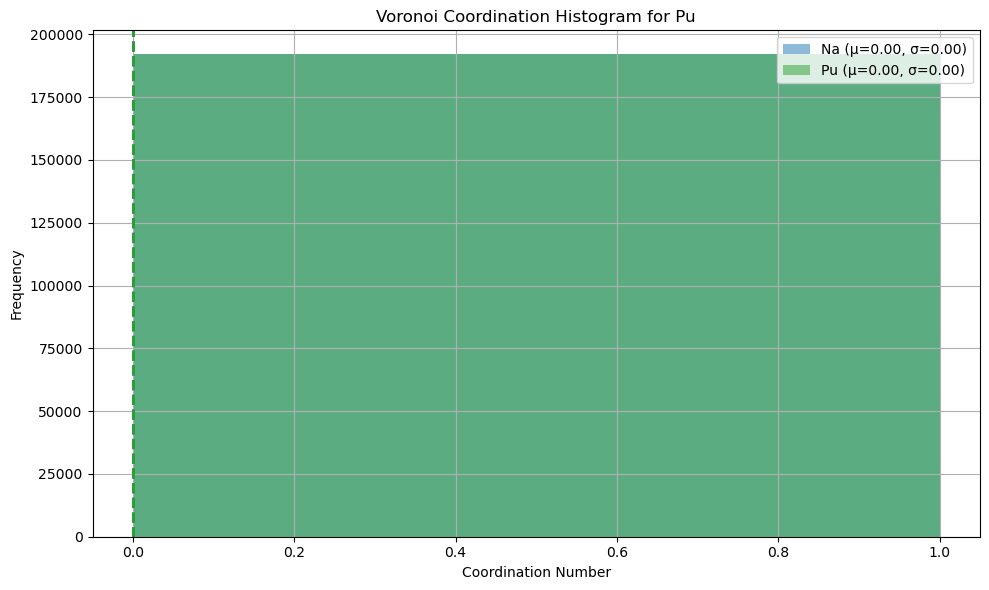

Plotting metal-metal coordination for Na


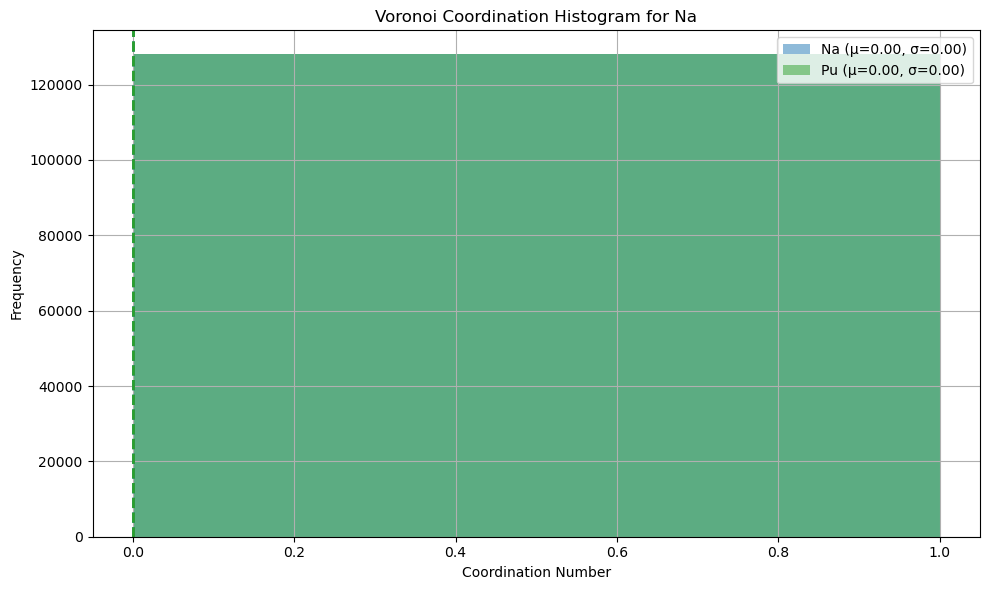

In [4]:
# Coordination analysis (full and metals-only)
print('Analyzing coordination (all species)...')
coord_all = analyze_voronoi_coordination(atoms_list, at_list=all_species, min_area=MIN_AREA)
for sp in all_species:
    print(f'Plotting coordination for {sp}')
    plot_coordination_histograms(coord_all, sp)

print('Analyzing coordination (metals-only)...')
coord_metals = analyze_voronoi_coordination_metals_only(atoms_list, metal_species=METAL_SPECIES, min_area=MIN_AREA)
for sp in METAL_SPECIES:
    print(f'Plotting metal-metal coordination for {sp}')
    plot_coordination_histograms(coord_metals, sp)


In [5]:
# Build sample-frame Voronoi graphs and summarize
sample_atoms = atoms_list[0]
print(f'Building full Voronoi graph (min_area={MIN_AREA})')
G_full = build_voronoi_graph(sample_atoms, min_area=MIN_AREA)
props_full = analyze_graph_properties(G_full)
print('Full graph properties:', props_full)

print(f'Building metals-only Voronoi graph (min_area={MIN_AREA})')
G_metals = build_voronoi_graph_metals_only(sample_atoms, min_area=MIN_AREA, metal_species=METAL_SPECIES)
props_metals = analyze_graph_properties(G_metals)
print('Metals graph properties:', props_metals)

if G_metals.number_of_edges() > 0:
    plot_graph_structure(G_metals, f'Metals-only Voronoi Graph (min_area={MIN_AREA})')


Building full Voronoi graph (min_area=50)
Full graph properties: {'num_nodes': 2048, 'num_edges': 0, 'density': 0, 'species_counts': {'Cl': 1408, 'Na': 256, 'Pu': 384}, 'is_connected': False, 'num_components': 2048, 'largest_component_size': 1, 'largest_component_fraction': 0.00048828125, 'avg_degree': 0.0, 'std_degree': 0.0, 'max_degree': 0, 'min_degree': 0, 'species_avg_degrees': {'Cl': 0.0, 'Na': 0.0, 'Pu': 0.0}, 'avg_facet_area': 0.0, 'std_facet_area': 0.0, 'min_facet_area': 0.0, 'max_facet_area': 0.0}
Building metals-only Voronoi graph (min_area=50)
Metals graph properties: {'num_nodes': 640, 'num_edges': 0, 'density': 0, 'species_counts': {'Na': 256, 'Pu': 384}, 'is_connected': False, 'num_components': 640, 'largest_component_size': 1, 'largest_component_fraction': 0.0015625, 'avg_degree': 0.0, 'std_degree': 0.0, 'max_degree': 0, 'min_degree': 0, 'species_avg_degrees': {'Na': 0.0, 'Pu': 0.0}, 'avg_facet_area': 0.0, 'std_facet_area': 0.0, 'min_facet_area': 0.0, 'max_facet_area': 0

Analyzing clusters (metals-only)...
Clusters: 640, largest: 1


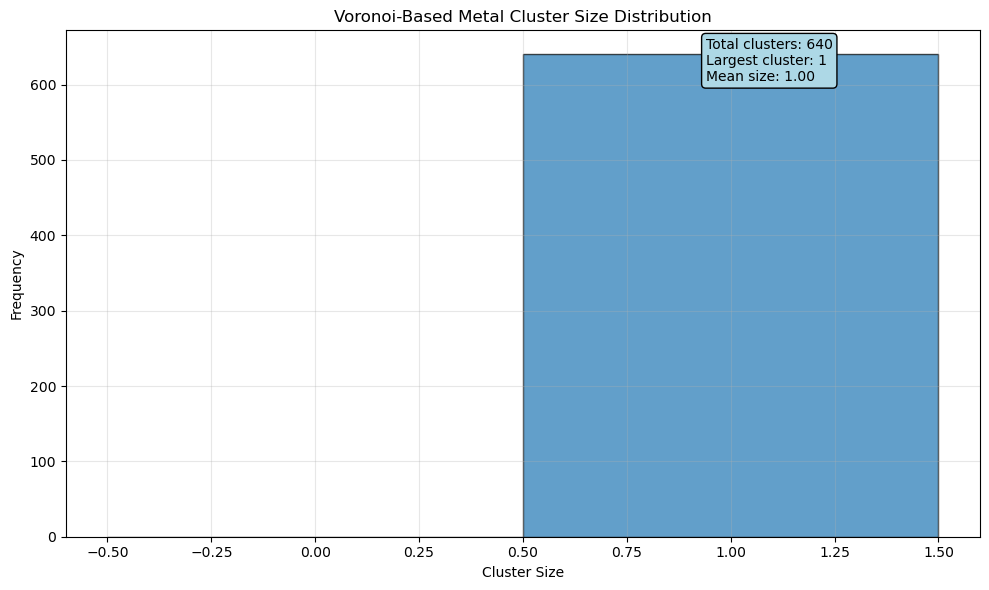

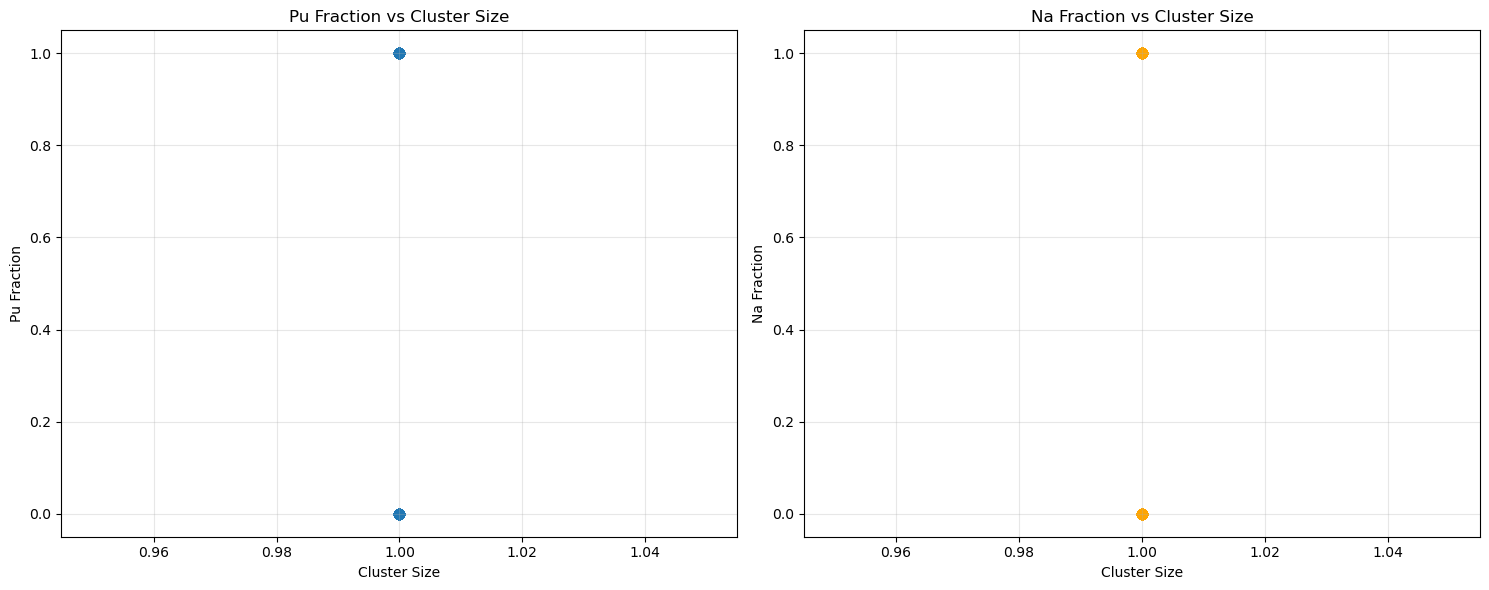

Cluster Composition Analysis:
Total clusters: 640
Pure Pu clusters: 384
Pure Na clusters: 256
Mixed clusters: 0


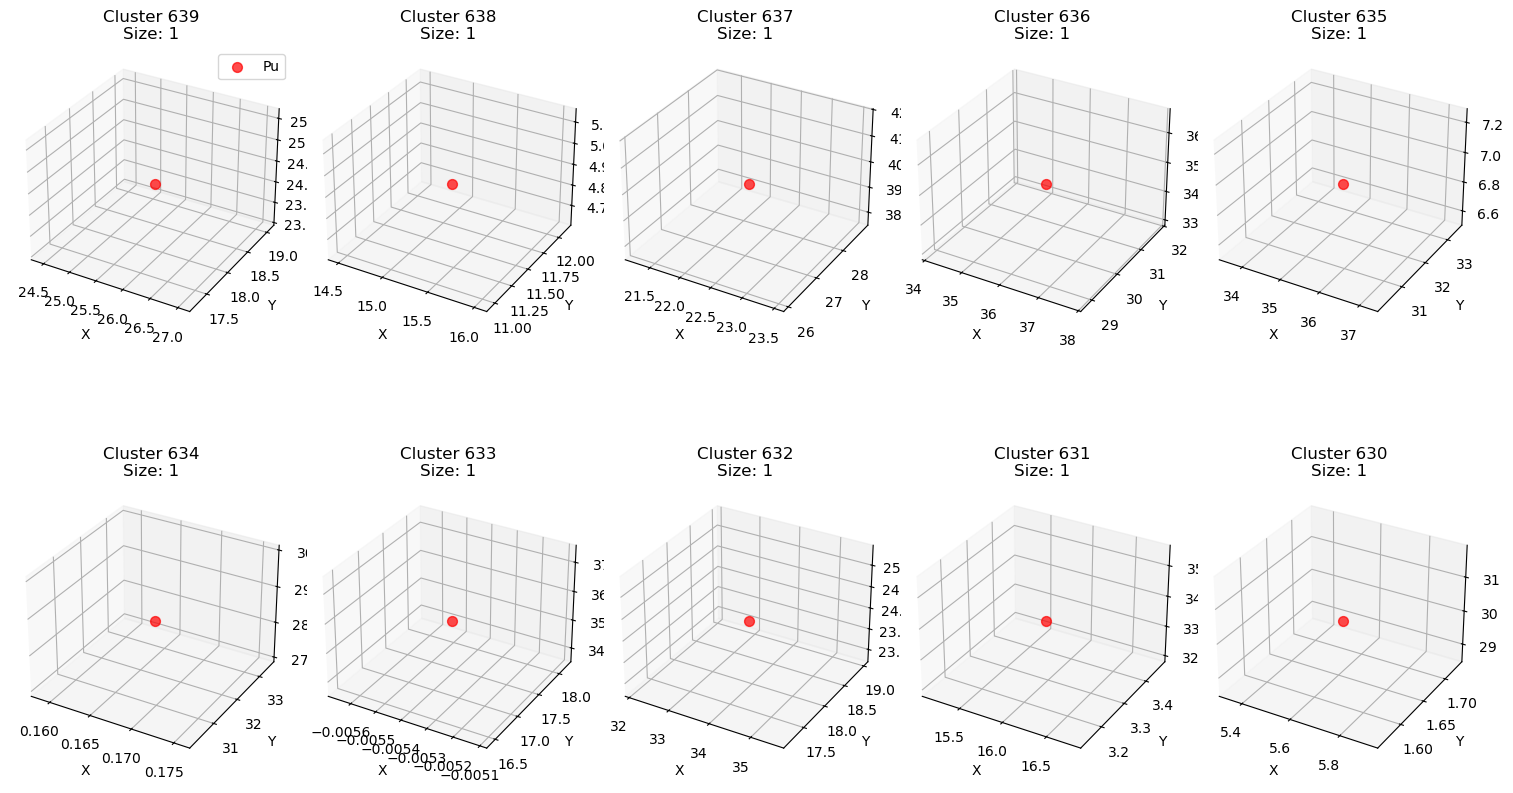

In [6]:
# Metals-only cluster analysis and plots
print('Analyzing clusters (metals-only)...')
cluster_sizes, cluster_ids, Gc = analyze_voronoi_clusters(sample_atoms, min_area=MIN_AREA, metal_species=METAL_SPECIES)
print(f'Clusters: {len(cluster_sizes)}, largest: {np.max(cluster_sizes) if len(cluster_sizes) else 0}')

if len(cluster_sizes) > 0:
    plot_cluster_size_distribution(cluster_sizes, 'Voronoi-Based Metal Cluster Size Distribution')

names0 = np.array(sample_atoms.get_chemical_symbols())
if len(cluster_sizes) > 0:
    _ = plot_cluster_composition_analysis(sample_atoms, cluster_ids, names0)
    plot_3d_cluster_visualization(sample_atoms, cluster_ids, names0, max_clusters=10)


In [7]:
# Voronoi edge network summary (by species pairs)
print('Voronoi edge network (full graph):')
_ = summarize_voronoi_edge_network(G_full, plot=True)

print('Voronoi edge network (metals-only):')
_ = summarize_voronoi_edge_network(G_metals, plot=True)


Voronoi edge network (full graph):
Voronoi edge network (metals-only):


Analyzing temporal graph properties...


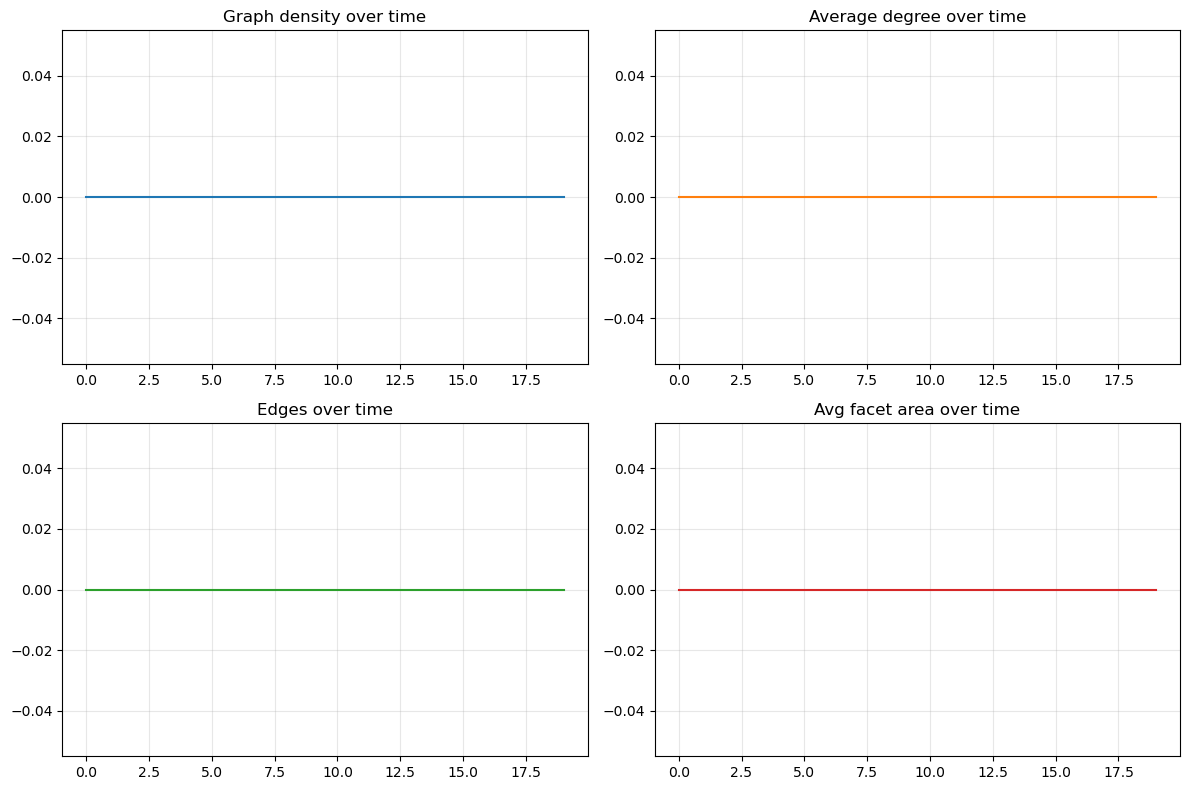

In [8]:
# Temporal evolution of graph properties
print('Analyzing temporal graph properties...')
temporal = analyze_temporal_graph_properties(atoms_list, min_area=MIN_AREA, sample_frames=20)
plot_temporal_graph_properties(temporal)


3D cluster visualization with edges (metals-only)...
Cluster 639: no edges to draw
Cluster 638: no edges to draw
Cluster 637: no edges to draw
Cluster 636: no edges to draw
Cluster 635: no edges to draw
Cluster 634: no edges to draw
Cluster 633: no edges to draw
Cluster 632: no edges to draw
Cluster 631: no edges to draw
Cluster 630: no edges to draw


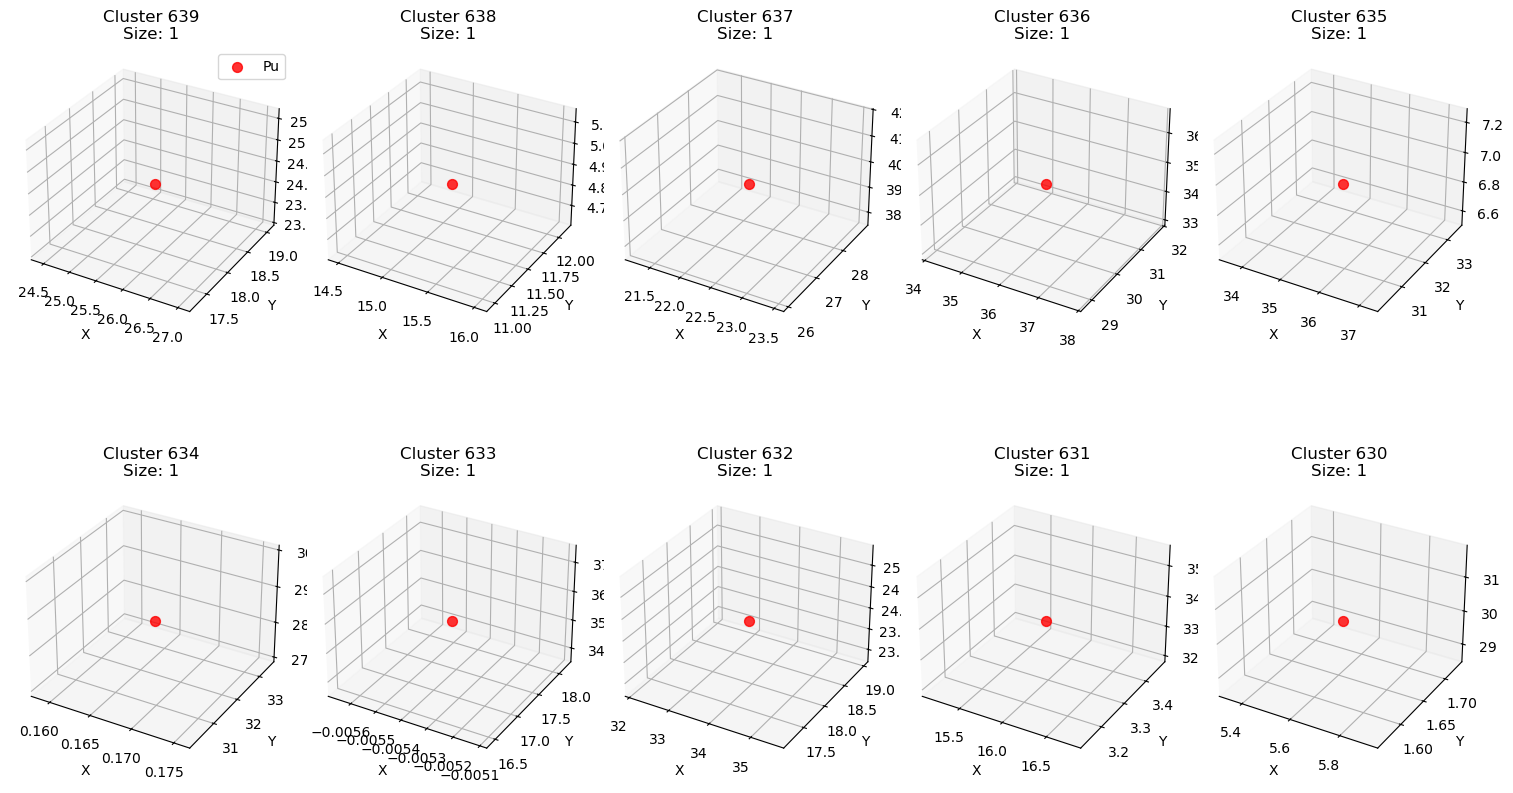

In [9]:
# 3D cluster visualization with graph edges (metals-only)
from voronoi_utils import plot_3d_cluster_with_graph
print('3D cluster visualization with edges (metals-only)...')
plot_3d_cluster_with_graph(sample_atoms, cluster_ids, names0, Gc, max_clusters=10)


Graph-only 3D components view (metals-only graph) ...


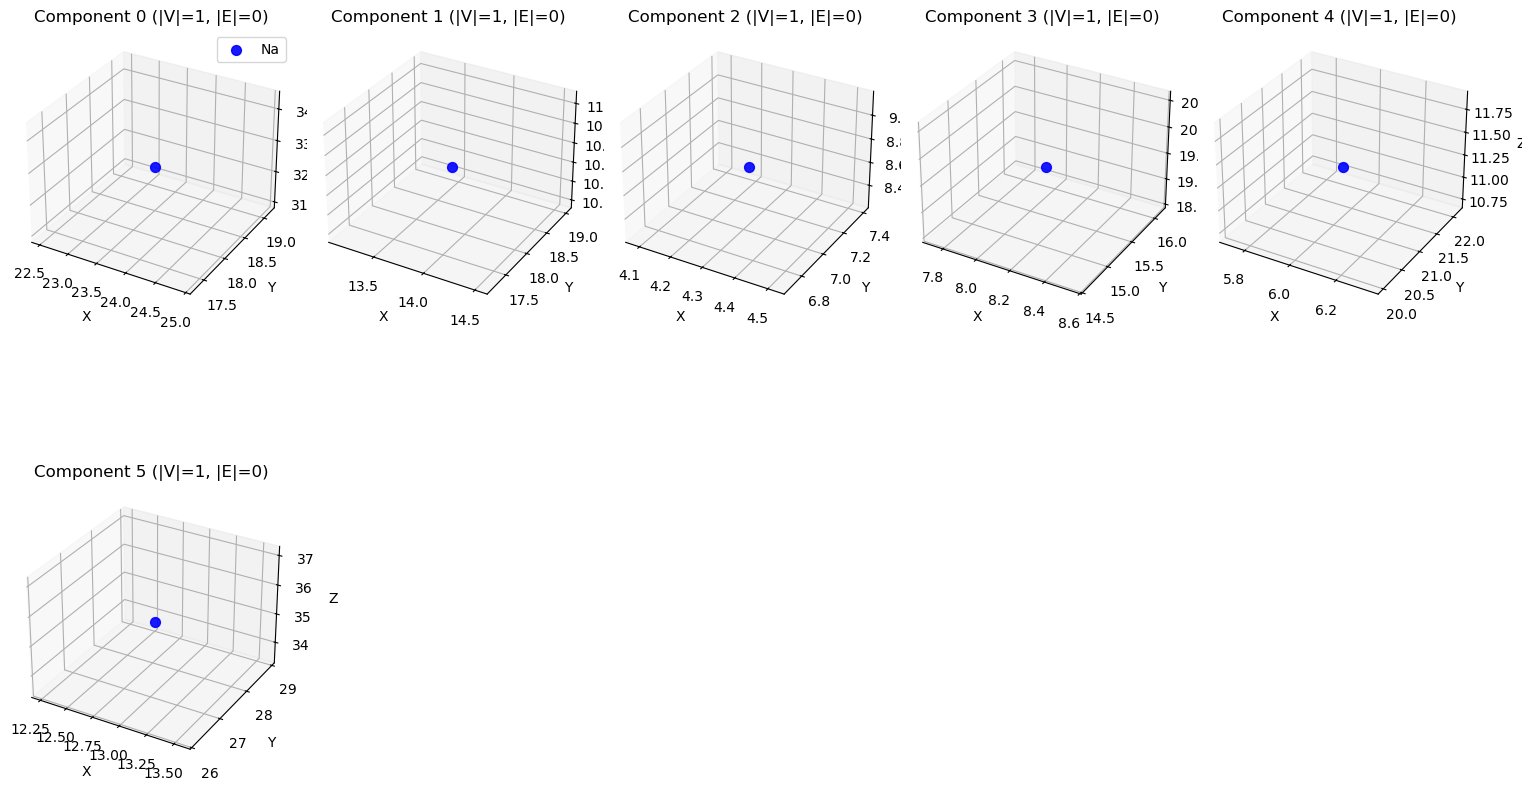

In [10]:
# Graph-only 3D visualization (largest connected components)
from plot_utils import plot_3d_graph_components
print('Graph-only 3D components view (metals-only graph) ...')
plot_3d_graph_components(Gc, max_components=6)


Cluster 639: no edges to draw
Cluster 638: no edges to draw
Cluster 637: no edges to draw
Cluster 636: no edges to draw
Cluster 635: no edges to draw
Cluster 634: no edges to draw
Cluster 633: no edges to draw
Cluster 632: no edges to draw
Cluster 631: no edges to draw
Cluster 630: no edges to draw


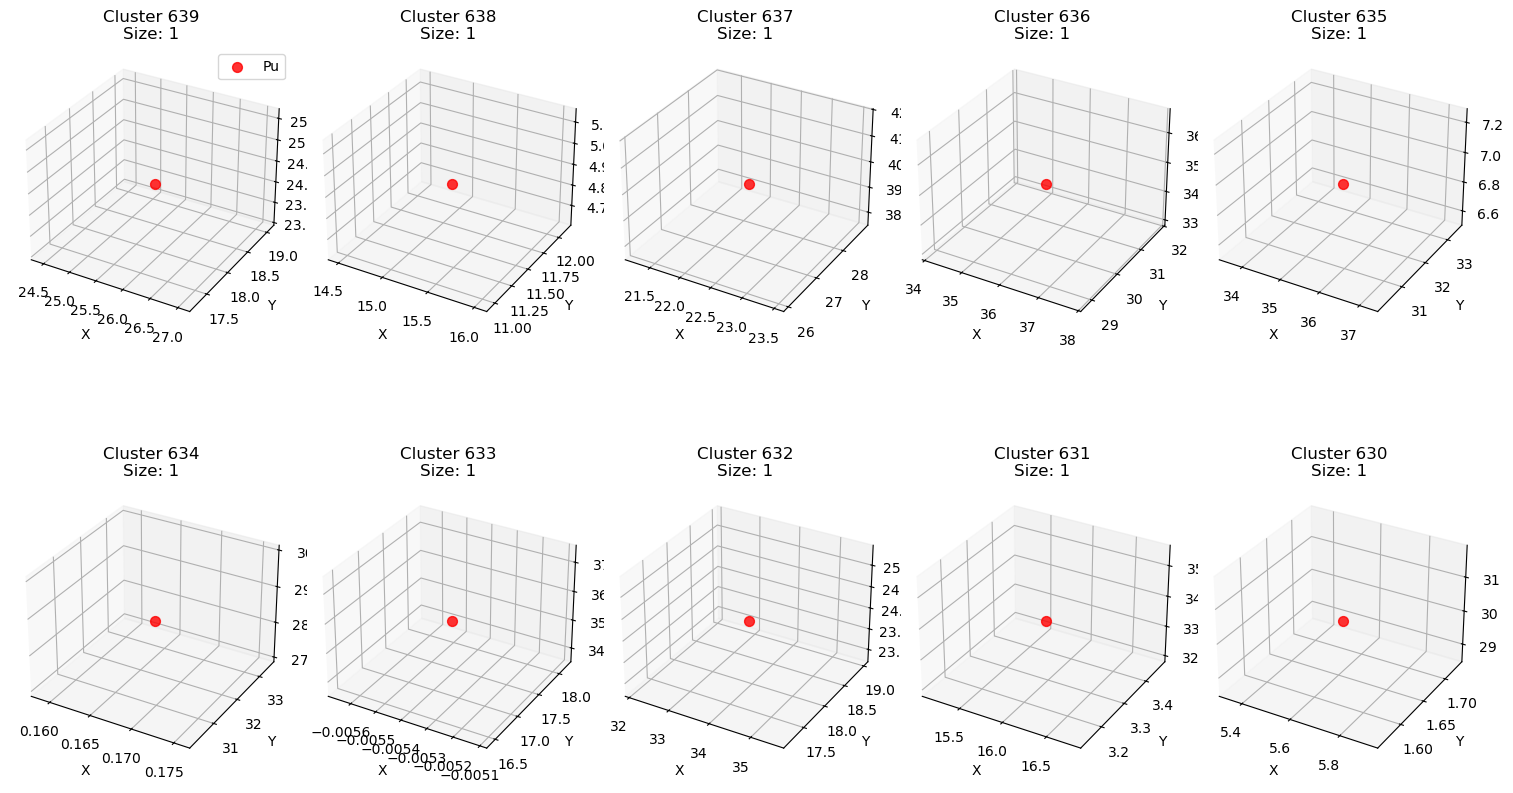

In [11]:
plot_3d_cluster_with_graph(sample_atoms, cluster_ids, names0, max_clusters=10, G=G_full)

In [12]:
G_full.edges()



EdgeView([])

In [13]:
def plot_3d_graph_components(G, max_components) -> None:
    """3D visualization of the largest connected components of a graph.

    Uses only the graph `G`. Nodes must have `position` (3-vector) and
    optionally `species` (e.g., "Na", "Pu"). Edges are drawn with linewidth
    mapped to edge "area" when present.
    """
    if nx is None:
        raise ImportError("networkx is required for plot_3d_graph_components")

    # Local import to avoid global dependency in headless environments
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  # pylint: disable=unused-import

    if G.number_of_nodes() == 0:
        print("Graph is empty")
        return

    # Connected components sorted by size
    components = sorted(nx.connected_components(G), key=len, reverse=True)
    components = components[:max_components]

    n = len(components)
    nrows, ncols = 2, 5
    nplots = max(n, 1)

    fig = plt.figure(figsize=(15, 10))

    species_colors = {"Na": "blue", "Pu": "red", "Cl": "green"}

    def lw_from_area(a: float, a0: float, a1: float) -> float:
        if a1 <= a0:
            return 1.0
        t = (float(a) - a0) / (a1 - a0)
        return 0.6 + 2.4 * max(0.0, min(1.0, t))

    for i, nodes in enumerate(components):
        ax = fig.add_subplot(nrows, ncols, i + 1, projection="3d")
        subG = G.subgraph(nodes)

        # Collect positions by species
        pos_by_species: Dict[str, List[np.ndarray]] = {}
        for n in subG.nodes:
            pos = np.asarray(subG.nodes[n].get("position"))
            if pos is None or pos.shape[0] != 3:
                continue
            sp = str(subG.nodes[n].get("species", "unknown"))
            pos_by_species.setdefault(sp, []).append(pos)

        # Scatter by species
        for sp, arrs in pos_by_species.items():
            P = np.vstack(arrs) if len(arrs) > 0 else None
            if P is None:
                continue
            color = species_colors.get(sp, "#666666")
            ax.scatter(P[:, 0], P[:, 1], P[:, 2], c=color, s=50, alpha=0.9, label=sp)

        # Edge linewidths by area when available
        areas = [edata.get("area", 1.0) for _, _, edata in subG.edges(data=True)]
        a_min = float(np.min(areas)) if len(areas) > 0 else 1.0
        a_max = float(np.max(areas)) if len(areas) > 0 else 1.0

        for u, v, edata in subG.edges(data=True):
            p1 = np.asarray(subG.nodes[u].get("position"))
            p2 = np.asarray(subG.nodes[v].get("position"))
            if p1 is None or p2 is None:
                continue
            lw = lw_from_area(edata.get("area", 1.0), a_min, a_max)
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color="#888888", alpha=0.6, linewidth=lw)

        ax.set_title(f"Component {i} (|V|={subG.number_of_nodes()}, |E|={subG.number_of_edges()})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        if i == 0 and len(pos_by_species) > 0:
            ax.legend()

    plt.tight_layout()
    plt.show()

In [14]:
G_full.

SyntaxError: invalid syntax (3584171031.py, line 1)

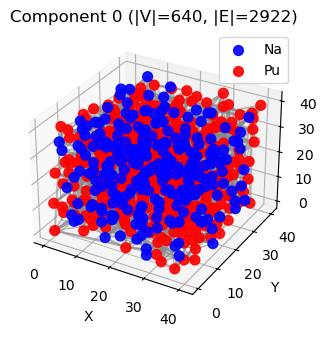

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
plot_3d_graph_components(G_metals, 10)

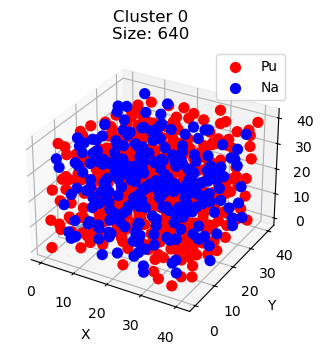

In [ ]:
plot_3d_cluster_with_graph_lines(sample_atoms, cluster_ids, names0, G_full, 10)

In [ ]:
# Average cluster size vs facet area (min_area) sweep
 generate
import numpy as np
import matplotlib.pyplot as plt
from voronoi_utils import build_voronoi_graph_metals_only, analyze_voronoi_clusters

sample_atoms = atoms_list[0]

# Gather facet areas from metals-only Voronoi edges at min_area=0
G_tmp = build_voronoi_graph_metals_only(sample_atoms, min_area=0.0, metal_species=METAL_SPECIES)
edge_areas = np.array([edata.get('area', 0.0) for _, _, edata in G_tmp.edges(data=True)], float)

# Define threshold sweep
if edge_areas.size == 0:
    thresholds = np.linspace(0.0, 1.0, 21)
else:
    low = float(np.quantile(edge_areas, 0.00))
    high = float(np.quantile(edge_areas, 0.80))
    thresholds = np.linspace(low, high if high > low else low + 1.0, 25)

avg_sizes = []
for t in thresholds:
    sizes, _, _ = analyze_voronoi_clusters(sample_atoms, min_area=float(t), metal_species=METAL_SPECIES)
    avg_sizes.append(float(np.mean(sizes)) if sizes.size > 0 else 0.0)

plt.figure(figsize=(6, 4))
plt.plot(thresholds, avg_sizes, marker='o')
plt.xlabel('min_area (facet area threshold)')
plt.ylabel('Average cluster size')
plt.title('Average cluster size vs facet area (metals-only)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
